In [23]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import datetime
import utils

In [11]:
raw_df = pd.read_csv("../../../../../Downloads/Datasets/Food_Establishment_Inspection_Data.csv")

/tmp/ipykernel_24257/2975437111.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv("../../../../../Downloads/Datasets/Food_Establishment_Inspection_Data.csv")


In [12]:
# Data Wrangling
cols = { k:k.replace(' ','_').lower() for k in raw_df.keys()}
raw_df = raw_df.rename(columns=cols)
raw_df.city=raw_df.city.str.upper()
raw_df.drop(['program_identifier','inspection_business_name','inspection_serial_num','violation_record_id','business_id'], axis=1);
raw_df["inspection_date"]=pd.to_datetime(raw_df["inspection_date"])
raw_df['weekday'] = raw_df.inspection_date.dt.day_name()

raw_df.loc[raw_df['longitude'] > 122, 'longitude'] *=-1
not_valid_inspection_result_rows=raw_df[(raw_df.inspection_result !='Unsatisfactory') & (raw_df.inspection_result !='Complete') &
(raw_df.inspection_result !='Incomplete') & (raw_df.inspection_result !='Satisfactory')]
raw_df.drop(not_valid_inspection_result_rows.index, inplace=True)

dropindex = raw_df[raw_df['inspection_score']<0 ].index
raw_df.drop(dropindex, inplace=True)

raw_df['name'] = raw_df.name.str.strip()
df = raw_df.reindex()

df['inspection_closed_business'].replace({False: 0, True: 1}, inplace=True)
# df.to_csv('basic_df.csv')

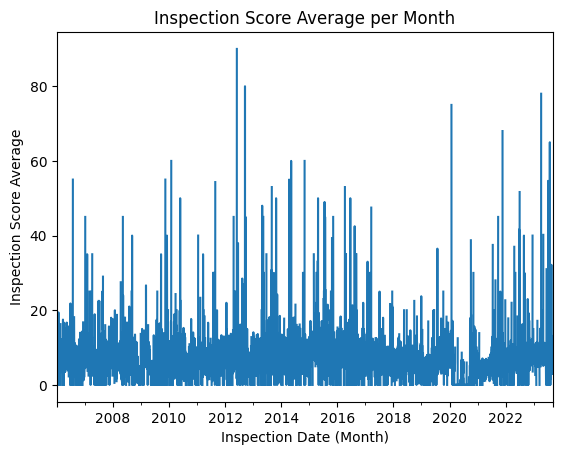

In [29]:
# Plot of Inspection Score Average per Month
grouped_df=df.groupby(['name', 'inspection_date', 'inspection_closed_business'])['violation_points'].sum().reset_index().rename(columns={'violation_points': 'inspection_score'})
grouped_df_time_series = grouped_df.set_index('inspection_date')
grouped_df_time_series['inspection_score'].resample('M').mean().plot()
plt.title('Inspection Score Average per Month')
plt.xlabel('Inspection Date (Month)')
plt.ylabel('Inspection Score Average')
grouped_df.to_csv('file1.csv')


In [14]:
grouped_df.loc[(grouped_df['inspection_closed_business']==1)&(grouped_df['inspection_score']==0)&(df['description'].str.contains('Seating')),:].count()

name                          12
inspection_date               12
inspection_closed_business    12
inspection_score              12
dtype: int64

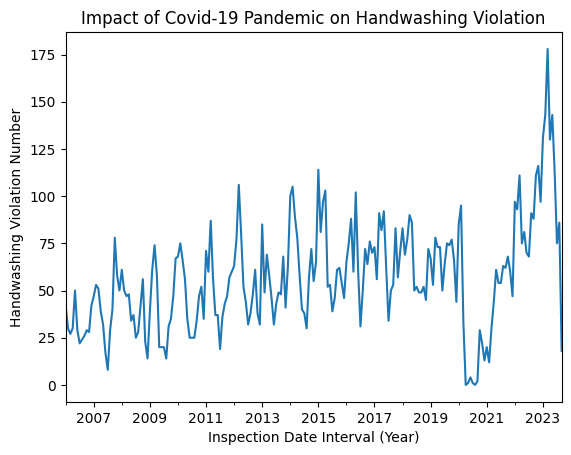

In [30]:
# Impact of Covid-19 Pandemic on Handwashing Violation
df_vio_desc = df.loc[(df['violation_description'].str.contains('hand')==True) & (df['violation_description'].str.contains('wash')==True),['inspection_date', 'violation_description']]
#df_vio_desc[(df_vio_desc['inspection_date']>'2006-12-31')&(df_vio_desc['inspection_date']<'2007-12-31')].count()
df_vio_desc_time_series = df_vio_desc.set_index('inspection_date')
df_vio_desc_time_series['violation_description'].resample('M').count().plot()
plt.title('Impact of Covid-19 Pandemic on Handwashing Violation')
plt.xlabel('Inspection Date Interval (Year)')
plt.ylabel('Handwashing Violation Number')
utils.save_report(df_vio_desc_time_series,filename='covid_impact',file_type='csv')

In [16]:
pd.to_datetime(grouped_df['inspection_date']).dt.month.value_counts()

inspection_date
3     16971
10    15299
1     15245
2     14904
4     14629
5     14192
11    12635
9     12530
12    11805
6     10776
8      9381
7      8198
Name: count, dtype: int64

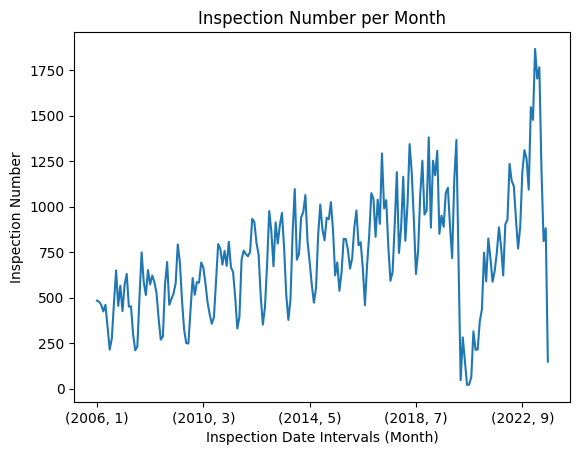

In [17]:
# Number of inspection
grouped_df=df.groupby(['name', 'inspection_date', 'inspection_closed_business'])['violation_points'].sum().reset_index().rename(columns={'violation_points': 'inspection_score'})
grouped_df['year'] = grouped_df['inspection_date'].dt.year
grouped_df['month'] = grouped_df['inspection_date'].dt.month
grouped_time = grouped_df.groupby(['year', 'month']).size()
grouped_time.plot()
plt.title('Inspection Number per Month')
plt.xlabel('Inspection Date Intervals (Month)')
plt.ylabel('Inspection Number')
grouped_df.to_csv('file2.csv')

In [41]:
# grouped_time.loc[grouped_time['year']==2006]
grouped_time

MultiIndex([(2006,  1),
            (2006,  2),
            (2006,  3),
            (2006,  4),
            (2006,  5),
            (2006,  6),
            (2006,  7),
            (2006,  8),
            (2006,  9),
            (2006, 10),
            ...
            (2022, 12),
            (2023,  1),
            (2023,  2),
            (2023,  3),
            (2023,  4),
            (2023,  5),
            (2023,  6),
            (2023,  7),
            (2023,  8),
            (2023,  9)],
           names=['year', 'month'], length=213)

In [32]:
my_df = df.groupby(['name', 'latitude', 'longitude', 'inspection_date', 'inspection_closed_business']).sum().reset_index()
my_df.to_csv('file3.csv')
# Seating
my_df_revised = my_df.loc[my_df['description'].str.contains('Seating'), ['name', 'latitude', 'longitude', 'inspection_date', 'inspection_closed_business']]
my_df_revised_close=my_df_revised.groupby(['name', 'latitude', 'longitude'])['inspection_closed_business'].sum().reset_index().rename(columns={'inspection_closed_business': 'close_count'})
df_before_corona = my_df_revised.loc[my_df_revised['inspection_date'] < '2019-03-11']
df_after_corona = my_df_revised.loc[my_df_revised['inspection_date'] > '2023-01-01']
df_before_corona_close_count=df_before_corona.groupby(['name', 'latitude', 'longitude'])['inspection_closed_business'].sum().reset_index().rename(columns={'inspection_closed_business': 'close_count'})
df_after_corona_close_count=df_after_corona.groupby(['name', 'latitude', 'longitude'])['inspection_closed_business'].sum().reset_index().rename(columns={'inspection_closed_business': 'close_count'})


#Not Seating
my_df_revised_not_Seating = my_df.loc[~my_df['description'].str.contains('Seating'), ['name', 'latitude', 'longitude', 'inspection_date', 'inspection_closed_business']]
df_before_corona_not_Seating = my_df_revised_not_Seating.loc[my_df_revised_not_Seating['inspection_date'] < '2019-03-11']
df_after_corona_not_Seating = my_df_revised_not_Seating.loc[my_df_revised_not_Seating['inspection_date'] > '2023-01-01']
df_before_corona_close_count_not_Seating=df_before_corona_not_Seating.groupby(['name', 'latitude', 'longitude'])['inspection_closed_business'].sum().reset_index().rename(columns={'inspection_closed_business': 'close_count'})
df_after_corona_close_count_not_Seating=df_after_corona_not_Seating.groupby(['name', 'latitude', 'longitude'])['inspection_closed_business'].sum().reset_index().rename(columns={'inspection_closed_business': 'close_count'})

# Bakery
my_df_revised_bakery = my_df.loc[my_df['description'].str.contains('Bakery'), ['name', 'latitude', 'longitude', 'inspection_date', 'inspection_closed_business']]
my_df_revised_bakery_close=my_df_revised_bakery.groupby(['name', 'latitude', 'longitude'])['inspection_closed_business'].sum().reset_index().rename(columns={'inspection_closed_business': 'close_count'})
#my_df_revised_bakery_close.loc[my_df_revised_bakery_close['close_count']==1]


TypeError: can only concatenate str (not "int") to str

In [ ]:
# Count of close business for Seating description
# Befor covid-19
no_close_before_corona = df_before_corona_close_count.loc[df_before_corona_close_count['close_count']==0]
one_close_before_corona= df_before_corona_close_count.loc[df_before_corona_close_count['close_count'] ==1]
two_close_before_corona= df_before_corona_close_count.loc[df_before_corona_close_count['close_count'] ==2]
three_close_before_corona= df_before_corona_close_count.loc[df_before_corona_close_count['close_count'] ==3]
four_close_before_corona= df_before_corona_close_count.loc[df_before_corona_close_count['close_count'] ==4]
# After covid-19
no_close_after_corona = df_after_corona_close_count.loc[df_after_corona_close_count['close_count']==0]
one_close_after_corona= df_after_corona_close_count.loc[df_after_corona_close_count['close_count'] ==1]
two_close_after_corona= df_after_corona_close_count.loc[df_after_corona_close_count['close_count'] ==2]
three_close_after_corona= df_after_corona_close_count.loc[df_after_corona_close_count['close_count'] ==3]
four_close_after_corona= df_after_corona_close_count.loc[df_after_corona_close_count['close_count'] ==4]

In [ ]:
ax = no_close_before_corona.plot(kind='scatter', x='longitude', y='latitude', color='#ADD8E6', figsize=(8, 8))
one_close_before_corona.plot(kind='scatter',ax=ax, x='longitude', color='yellow', y='latitude')
two_close_before_corona.plot(kind='scatter',ax=ax, x='longitude', color='red', y='latitude')
three_close_before_corona.plot(kind='scatter',ax=ax, x='longitude', color='#9400D3', y='latitude')
four_close_before_corona.plot(kind='scatter',ax=ax, x='longitude', color='black', y='latitude')
plt.title('Number of closed Business before Covid-19 pandemic (Seating Type)')
plt.legend(["No closed", "1t Closed", "2t Closed", "3t Closed", "4t Closed"])

In [ ]:
ax = no_close_after_corona.plot(kind='scatter', x='longitude', y='latitude', color='#ADD8E6', figsize=(8, 8))
one_close_after_corona.plot(kind='scatter',ax=ax, x='longitude', color='yellow', y='latitude')
two_close_after_corona.plot(kind='scatter',ax=ax, x='longitude', color='red', y='latitude')
three_close_after_corona.plot(kind='scatter',ax=ax, x='longitude', color='#9400D3', y='latitude')
four_close_after_corona.plot(kind='scatter',ax=ax, x='longitude', color='black', y='latitude')
plt.title('Number of closed Business after Covid-19 pandemic (Seating Type)')
plt.legend(["No closed", "1t Closed", "2t Closed", "3t Closed", "4t Closed"])

In [ ]:
# Count of close business for Not-Seating description
# Befor covid-19
no_close_before_corona_not_Seating = df_before_corona_close_count_not_Seating.loc[df_before_corona_close_count_not_Seating['close_count']==0]
one_close_before_corona_not_Seating = df_before_corona_close_count_not_Seating.loc[df_before_corona_close_count_not_Seating['close_count'] ==1]
two_close_before_corona_not_Seating = df_before_corona_close_count_not_Seating.loc[df_before_corona_close_count_not_Seating['close_count'] ==2]
three_close_before_corona_not_Seating = df_before_corona_close_count_not_Seating.loc[df_before_corona_close_count_not_Seating['close_count'] ==3]
four_close_before_corona_not_Seating = df_before_corona_close_count_not_Seating.loc[df_before_corona_close_count_not_Seating['close_count'] ==4]
# After covid-19
no_close_after_corona_not_Seating = df_after_corona_close_count_not_Seating.loc[df_after_corona_close_count_not_Seating['close_count']==0]
one_close_after_corona_not_Seating = df_after_corona_close_count_not_Seating.loc[df_after_corona_close_count_not_Seating['close_count'] ==1]
two_close_after_corona_not_Seating = df_after_corona_close_count_not_Seating.loc[df_after_corona_close_count_not_Seating['close_count'] ==2]
three_close_after_corona_not_Seating = df_after_corona_close_count_not_Seating.loc[df_after_corona_close_count_not_Seating['close_count'] ==3]
four_close_after_corona_not_Seating = df_after_corona_close_count_not_Seating.loc[df_after_corona_close_count_not_Seating['close_count'] ==4]

In [ ]:
ax = no_close_before_corona_not_Seating.plot(kind='scatter', x='longitude', y='latitude', color='#ADD8E6', figsize=(8, 8))
one_close_before_corona_not_Seating.plot(kind='scatter',ax=ax, x='longitude', color='yellow', y='latitude')
two_close_before_corona_not_Seating.plot(kind='scatter',ax=ax, x='longitude', color='red', y='latitude')
three_close_before_corona_not_Seating.plot(kind='scatter',ax=ax, x='longitude', color='#9400D3', y='latitude')
four_close_before_corona_not_Seating.plot(kind='scatter',ax=ax, x='longitude', color='black', y='latitude')
plt.title('Number of closed Business before Covid-19 pandemic (Without Seating Type)')
plt.legend(["No closed", "1t Closed", "2t Closed", "3t Closed", "4t Closed"])

In [ ]:
ax = no_close_after_corona_not_Seating.plot(kind='scatter', x='longitude', y='latitude', color='#ADD8E6', figsize=(8, 8))
one_close_after_corona_not_Seating.plot(kind='scatter',ax=ax, x='longitude', color='yellow', y='latitude')
two_close_after_corona_not_Seating.plot(kind='scatter',ax=ax, x='longitude', color='red', y='latitude')
three_close_after_corona_not_Seating.plot(kind='scatter',ax=ax, x='longitude', color='red', y='latitude')
four_close_after_corona_not_Seating.plot(kind='scatter',ax=ax, x='longitude', color='black', y='latitude')
plt.title('Number of closed Business after Covid-19 pandemic (Without Seating Type)')
plt.legend(["No closed", "1t Closed", "2t Closed", "3t Closed", "4t Closed"])